# Using  `secsy` to solve the 2D steady state continuity equation


The steady-state continuty equation is 

$\nabla\cdot(\mathbf v n) = P - L$

where $\mathbf{v}$ is the (assumed to be known) 2D velocity, $n$ is the density, $P$ is the production rate, and $L$ is the loss rate. All quantities are functions of 2D space. I will assume that the flow is incompressible, and also that the loss term is proportional to the density: $L = \alpha n$. Then the equation becomes

$\mathbf{v} \cdot \nabla n + \alpha n = P$.

We see from this equation that in regions where the velocity is zero, $n = P/\alpha$. 

We will solve this equation using finite differences. To do that, we formulate it as a matrix equation. From now on, all vectors (bold symbols) represent the set of values of a particular quantity on a grid with $N$ cells. So for example $\mathbf{n}$ is a set of $N$ densities in the center of the $N$ grid cells in our grid. The matrix version of the above continuity equation can be written as

$\mathrm{diag}(\mathbf{v}_e) \mathbb D_e \mathbf{n} + \mathrm{diag}(\mathbf{v}_n) \mathbb D_n \mathbf{n} + \alpha \mathbb I \mathbf{n} = \mathbf{P}$

where the matrices $\mathbb D_e$ and $\mathbb D_n$, when multiplied by a vector like $\mathbf{n}$ that represents a scalar field on the $N$ cell grid, yields the eastward and northward-components of the gradient of that quantity, respectively. That is, the matrices contain the finite difference scheme. Collecting terms with $\mathbf{n}$:

$\left(\mathrm{diag}(\mathbf{v}_e) \mathbb D_e + \mathrm{diag}(\mathbf{v}_n) \mathbb D_n + \alpha \mathbb I\right) \mathbf{n} = \mathbf{P}$, which can be inverted for $\mathbf{n}$ under some conditions. 

In the `secsy` module,  $\mathbb D_e$ and $\mathbb D_n$ can be calculated with the `get_Le_Ln` function. An arbitrarily large stencil can be used. Note that, the matrices returned by this function imply open boundary conditions, which puts restrictions on what kind of problem can be solved in this way. In our case, it works because we make the domain large enought that in our region of interest, no plasma flows in or out. 

Below I will
 1. Set up the grid
 2. Read a Weimer model output file and calculate $\mathbf{v}$ on the grid
 3. Define a production rate on each grid cell, $\mathbf P$
 4. Solve and plot (given some loss rate $\alpha$)



In [1]:
%matplotlib inline
from lompe.secsy import cubedsphere as cs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import sparse
from scipy.ndimage import median_filter
from scipy.sparse.linalg import spsolve
from lompe.utils.coords import sph_to_car

plt.matplotlib.rc('font', **{'size':14})

R = 6371.2e3 # Earth radius
B0 = 3.12e-5 # Mean magnetic field
stencil_size = 1 # size of the stencil used for numerical differentiation
P0 = 1 # The plasma production rate at the subsolar point (not realistic, but we show normalized results)
alpha = 1 / (4* 60**2) # Time in seconds for plasma to decay by a factor 1/e


# set up grid:
projection = cs.CSprojection((0, 90.), 0)
grid = cs.CSgrid(projection, 18000e3, 18000e3, 20e3, 20e3, R = R)
SKIP = 20 # how many grid points to skip when plotting vector fields


Next, read Weimer module output file, add cororotation to move to a Sun-fixed frame, and calculate $\mathbf v$ on the grid, assuming a dipole magnetic field. Note that we have to interpolate the potential to the cubed sphere grid, and then smooth the electric field. 

In [2]:
# read potential file:
weimer = pd.read_table('./datasets/weimer.txt', sep = ' ', skipinitialspace=True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# prepare to differentiate to get electric field components
dlat, dlon = 0.5, 2. # degrees
latxx = weimer.mlat.values.reshape((181, 61))[:, 3:]
lonxx = weimer.mlt. values.reshape((181, 61))[:, 3:] * 15 # mlt to lon
V     = weimer.phi .values.reshape((181, 61))[:, 3:] * 1e3 # kV to V


# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'linear').reshape(grid.shape)

# add corotation electric potential
V = V - B0 * R**2 * np.cos(grid.lat * np.pi  / 180)**2 * 2 * np.pi / (24 * 60**2)

# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)
E_e = -De.dot(V.flatten()).reshape(grid.shape)

# smooth the electric field a bit:
E_e = median_filter(E_e, size = 4*SKIP, mode = 'constant', cval = 0)
E_n = median_filter(E_n, size = 4*SKIP, mode = 'constant', cval = 0)

E_n[grid.lat < 60] = 0 # set to zero flow somewhere below the heppner-maynard boundary

# calculate dipole magnetic field radial components and absolute values
B_r = -2 * B0 * np.sin(grid.lat * np.pi / 180) 
B   =      B0 * np.sqrt(1 + 3 * np.sin(grid.lat * np.pi / 180)**2)

# calulate velocity components 
v_e =  E_n * B_r/B**2
v_n = -E_e * B_r/B**2



The next step is to define a production pattern. I will assume that the production is dependent on the solar zenith angle, and calculate the solar zenith angle with some made-up latitude for the subsolar point

In [3]:
def get_sza(lat, lon, sslat):
    """ 
    Return solar zenith angle, in radians
    maximum value is pi/2.

    lat is the latitudes where we evaluate the sza
    lon is the *local times* where we evaluate the sza

    sslat is the latitude of the subsolar point
    """
    
    shape = lat.shape
    colat = (90 - lat).flatten() 
    lt    = lon.flatten()/15

    sslt = 12

    # compute and return the angle
    ssr = sph_to_car(np.vstack((np.ones_like(sslat), 90. - sslat, sslt * 15)), deg = True)
    gcr = sph_to_car(np.vstack((np.ones_like(colat),  colat  , lt * 15 )), deg = True)

    # the angle is arccos of the dot product of these two vectors
    sza = np.arccos(np.sum(ssr*gcr, axis = 0))
    sza[sza > np.pi/2] = np.pi/2
    return sza.reshape(shape)


sza = get_sza(grid.lat, grid.lon, 10) # last number is roughly dipole tilt angle

P = P0 * np.cos(sza) # this is the plasma production function



Finally we solve. Note that `get_Le_Ln` returns sparse matrices, so that we can use `scipy`s `spsolve` function to solve for $n$

In [4]:

# get differentiation matrices:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
I  = sparse.identity(grid.size)
Ve = sparse.diags(v_e.flatten())
Vn = sparse.diags(v_n.flatten())

G = Ve * De + Vn * Dn + alpha * I

# solve:
n = spsolve(G, P.flatten())

# mask the density below the zero-flow boundary: 
n[grid.lat.flatten() < 60] = np.nan

# normalize the result relative to peak density for v = 0
n = n / (P0 / alpha) 



Finally, plot the input and output

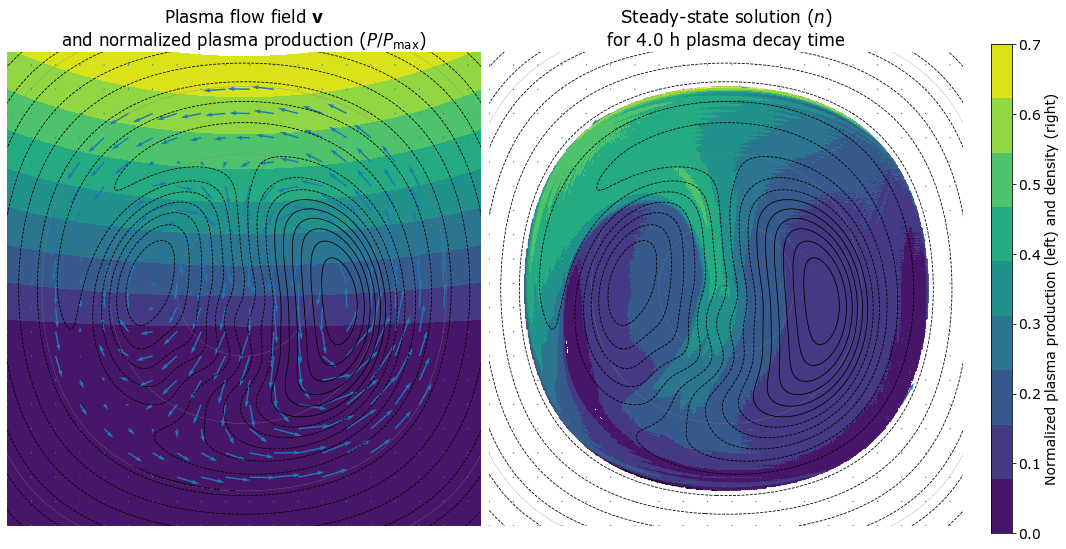

In [5]:
# plot potential, velocities, and production
fig = plt.figure(figsize = (18, 9))
axes = [plt.subplot2grid((1, 21), (0, i*10), colspan = 10) for i in [0, 1]]
cbar = plt.subplot2grid((1, 41), (0, 40))
clevels = np.linspace(0, .7, 10) # color levels for the relative density
ncols = clevels.size

axes[0].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
axes[0].contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-500:501:4] * 1e3, linewidths = .8)
axes[0].contourf(grid.xi, grid.eta, P.reshape(grid.shape) / P0, levels = clevels)

vxi, veta = grid.projection.vector_cube_projection(v_e.flatten(), v_n.flatten(), grid.lon.flatten(), grid.lat.flatten(), return_xi_eta = False)
vxi, veta = vxi.reshape(grid.shape), veta.reshape(grid.shape)

axes[0].quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], veta[::SKIP, ::SKIP], scale = 5000, color = 'C0')

axes[0].set_aspect('equal')
axes[0].set_axis_off()
axes[0].set_title('Plasma flow field $\mathbf{v}$\nand normalized plasma production ($P/P_{\mathrm{max}}$)')



# plot potential, velocities, and solution
axes[1].contour( grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
axes[1].contour( grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)

axes[1].quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], veta[::SKIP, ::SKIP], scale = 5000, color = 'C0')
axes[1].contourf(grid.xi, grid.eta, n.reshape(grid.shape), levels = clevels)

axes[1].set_aspect('equal')
axes[1].set_axis_off()
axes[1].set_title('Steady-state solution ($n$)\nfor {0:.2} h plasma decay time'.format(1/alpha / 60**2))


# plot the colorbar
cbar.contourf( np.vstack((np.zeros(ncols), np.ones(ncols))), np.vstack((clevels, clevels)), np.vstack((clevels, clevels)), levels = clevels)
cbar.set_xticks([])
cbar.yaxis.tick_right()
cbar.yaxis.set_label_position('right')
cbar.set_ylabel('Normalized plasma production (left) and density (right)')

plt.show()

# save figure
fig.savefig('./output_figures/continuityexample.pdf')
fig.savefig('./output_figures/continuityexample.png')

